### Section 2 : 2D Stokes flow with non-linear boundary conditions

The objective of this section is to solve the stationary Stokes system in two dimensions, on a rectangular channel-like domain, with a non-linear boundary condition at the inlet.

The Stokes equations, which describe flows at low Reynolds numbers (viscous forces dominant and negligible inertia), can be written as:  

$$
\begin{cases}
- \nu \Delta \mathbf{u} + \nabla p = \mathbf{f}, \quad & \text{in } \Omega, \\\\
\nabla \cdot \mathbf{u} = 0, \quad & \text{in } \Omega,
\end{cases}
$$

where:
- $\mathbf{u} = (u_x, u_y)$ is the velocity field,  
- $p$ is the pressure,  
- $\nu$ is the kinematic viscosity,  
- $\mathbf{f}$ is a volumetric source term (here taken as zero).  

## Boundary conditions

The computational domain is a rectangle $[0,L] \times [0,H]$. The following boundary conditions are prescribed:

- **Top and bottom boundaries ($y=0$ and $y=H$)**  
  No-slip conditions:  
  $$
  \mathbf{u}(x,0) = \mathbf{u}(x,H) = (0,0).
  $$

- **Inlet boundary ($x=0$)**  
  A non-linear boundary conditions is implemented at the inlet, we choose it in such a way as to impose a parabole horizontal velocity profile :  
  $$
  u_x^2(0,y) = \left[ U_{\max}\left(1 - \left(\tfrac{2y - H}{H}\right)^2\right) \right]^2, 
  \quad u_y(0,y) = 0.
  $$

  with $U_{\max}$ the maximum velocity at the channel center.

- **Outlet boundary ($x=L$)**  
  The pressure is fixed to zero as a reference value:  
  $$
  p(L,y) = 0,
  $$
  while velocities are left free in order not to overconstrain the problem.  

---

This setup leads to a velocity field with an invariant parabolic profile across the channel length, and to a linear pressure decrease between inlet and outlet, which corresponds to the analytical Poiseuille solution in the Stokes regime.


## Section 1.1 : Import packages 

In [22]:
using Ferrite
using SparseArrays
using LinearAlgebra         # provides mul! 
using UnPack                # added for time integration using DifferentialEquations.jl 
using OrdinaryDiffEq        # added for time integration using DifferentialEquations.jl
using DifferentialEquations # added for time integration using DifferentialEquations.jl   
using StaticArrays    
using WriteVTK
using Plots                 # provides contour plot of cell averages 
using NLSolvers
using ForwardDiff
using Printf  
# using Sundials
using NLsolve
##using DiffEqBase: NLsolveJL
using NonlinearSolve

## Section 1.2 : Definition of the mesh, the boundary conditions, the initial condition, the quadrature etc.

In [23]:
# Mesh definition 
Lx = 4.0
Ly = 1.0 
h_x = 0.05
h_y = 0.01
nx = Int(Lx / h_x ) # 80 / 0.5
ny = Int(Ly / h_y) # 20 / 0.5
## grid creation
grid = generate_grid(Quadrilateral, (nx, ny), Vec((0.0, 0.0)), Vec((Lx, Ly)))
println("Nombre de noeuds : ", length(grid.nodes))
println("Nombre d'éléments : ", length(grid.cells))

# interpolation and quadrature
ipu = Lagrange{RefQuadrilateral, 2}()^2 # quadratic
ipp = Lagrange{RefQuadrilateral, 1}()   # linear
ipg = Lagrange{RefQuadrilateral, 1}() # linear geometric interpolation
qr = QuadratureRule{RefQuadrilateral}(4)
cvu = CellValues(qr, ipu, ipg)
cvp = CellValues(qr, ipp, ipg)
qr_facet = FacetQuadratureRule{RefQuadrilateral}(4)
fvu = FacetValues(qr_facet, ipu, ipg)
fvp = FacetValues(qr_facet, ipp, ipg)

# dof handler 
dh = DofHandler(grid)
add!(dh, :u, ipu)
add!(dh, :p, ipp)
close!(dh)

# constraint handler 
ch = ConstraintHandler(dh)
left_boundary = getfacetset(grid, "left")
## conditions on the top and on the bottom
Γ23 =  union(getfacetset(dh.grid, "top"), getfacetset(dh.grid, "bottom"),)
dbc = Dirichlet(:u, Γ23, (x, t) -> [0.0, 0.0], [1, 2])
add!(ch, dbc)
#dbc_outlet = Dirichlet(:p, getfacetset(dh.grid, "right"), (x, t) -> 0.0)
#add!(ch,dbc_outlet)
# Finalize
close!(ch)
update!(ch, 0.0)

Nombre de noeuds : 8181
Nombre d'éléments : 8000


## Section 1.3 : Assembly of the stifness matrix 

In [24]:

function assemble_stifness_matrix!(K, f, dh, cvu, cvp, μ)
    assembler = start_assemble(K, f)
    ke = zeros(ndofs_per_cell(dh), ndofs_per_cell(dh))
    fe = zeros(ndofs_per_cell(dh))
    range_u = dof_range(dh, :u)
    ndofs_u = length(range_u)
    range_p = dof_range(dh, :p)
    ndofs_p = length(range_p)
    ϕᵤ = Vector{Vec{2, Float64}}(undef, ndofs_u)
    ∇ϕᵤ = Vector{Tensor{2, 2, Float64, 4}}(undef, ndofs_u)
    divϕᵤ = Vector{Float64}(undef, ndofs_u)
    ϕₚ = Vector{Float64}(undef, ndofs_p)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cvu, cell)
        Ferrite.reinit!(cvp, cell)
        ke .= 0
        fe .= 0
        for qp in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, qp)
            for i in 1:ndofs_u
                ϕᵤ[i] = shape_value(cvu, qp, i)
                ∇ϕᵤ[i] = shape_gradient(cvu, qp, i)
                divϕᵤ[i] = shape_divergence(cvu, qp, i)
            end
            for i in 1:ndofs_p
                ϕₚ[i] = shape_value(cvp, qp, i)
            end
            # u-u
            for (i, I) in pairs(range_u), (j, J) in pairs(range_u)
                ke[I, J] += μ * (∇ϕᵤ[i] ⊡ ∇ϕᵤ[j]) * dΩ
            end
            # u-p
            for (i, I) in pairs(range_u), (j, J) in pairs(range_p)
                ke[I, J] += (-divϕᵤ[i] * ϕₚ[j]) * dΩ
            end
            # p-u
            for (i, I) in pairs(range_p), (j, J) in pairs(range_u)
                ke[I, J] += (-divϕᵤ[j] * ϕₚ[i]) * dΩ
            end
            # rhs
            for (i, I) in pairs(range_u)
                fe[I] += 0.0 # for the moment, we try for f=0
            end
        end
        assemble!(assembler, celldofs(cell), ke, fe)
    end
    return K, f
end

assemble_stifness_matrix! (generic function with 1 method)

## Section 1.4 : Definiton of the matrix and the parameters of the problem

In [25]:
# dynamic viscosity 
μ = 1e-3
# definition of the matrix
coupling = [true true; true false] # no coupling between pressure test/trial functions
K = allocate_matrix(dh, ch; coupling = coupling)
f = zeros(ndofs(dh))
K , f = assemble_stifness_matrix!(K, f, dh, cvu, cvp, μ); # assemble the system

jac_sparsity = sparse(K);
# RHS structure definition 
struct RHSparams
    K::SparseMatrixCSC
    f::Vector
    ch::ConstraintHandler
    dh::DofHandler
    cvu::CellValues
    fvu::FacetValues 
    boundary
    u::Vector
end 
u0 = zeros(ndofs(dh))
u0 .=1
apply!(u0, ch);
p = RHSparams(K, f, ch, dh, cvu, fvu, left_boundary, copy(u0));



## Section 1.5 : Definition and assembly of the residual and implementation of the non-linear BC

In [26]:
# Now, handle the nonlinear BC 
## Parabole velocity at the inlet (left boundary)
function parabole_velocity(x)
    y = x[2]
    H = 1.0
    ξ = (2*y - H)/H
    Vmax = 15
    vx = Vmax * (1 - ξ^2)
    vx = (vx^2)
    return vx
end
res_value(u_val, x) = (u_val[1]^2- parabole_velocity(x)) # à modifier 
dures_value(u_val,x) = 2.0 * u_val[1]
α = 1000000.0 # defining the penalty
tol_in = 0.011
H = 1.0

# Assembly of the non linear contribution in the residual
function assemble_nonlinear_residual!(Re::Vector, u_e::Vector, fvu::FacetValues, cvu::CellValues, facet)
    n_basefuncs_facet_u = getnbasefunctions(fvu)
    ndofs_u = 2  # nombre de composantes de vitesse en 2D
    # Element residual for the non linear CL
    # Loop over the quadrature points of the facet
    for q_point in 1:getnquadpoints(fvu)
        x = spatial_coordinate(fvu, q_point,getcoordinates(facet))
        dΓ = getdetJdV(fvu, q_point) # getting the weight 
        u_q_point = function_value(fvu, q_point, u_e)
        res_q_point = res_value(u_q_point, x) # residual compared to the target value 
        # Loop over the shape functions of the facet 
        for i in 1:n_basefuncs_facet_u
            if i%2 ==1 #test to modify only the horizontal velocity component
                if (x[2]<= tol_in || x[2] >= H - tol_in/2)
                    Re[i] -=0
                else
                    ϕ_vec = shape_value(fvu, q_point, i)  # VectorValue(ϕx, ϕy)
                    ϕx = ϕ_vec[1]
                    Re[i] -= α * res_q_point * ϕx * dΓ # contribution to the non linear residual
                end
            end
        end
    end 
    return
end 

function stokes_residual!(R, u_current, p::RHSparams)
    @unpack K, f, ch, dh, cvu, fvu, boundary, u = p  
    u .= u_current
    #update!(ch, t)
    apply!(u, ch)
    ## residual, linear contribution
    R .= f
    mul!(R, K, u, -1.0, 1.0)
    ## residual, non linear contribution 
    u_range = dof_range(dh, :u)
    ndofs_u = 2
    n_basefuncs_facet_u = getnbasefunctions(fvu)
    Re = zeros(n_basefuncs_facet_u)
    u_e = zeros(n_basefuncs_facet_u)
    for facet in FacetIterator(dh, boundary)
        Ferrite.reinit!(fvu, facet)
        u_boundary_facetdofs = @view celldofs(facet)[u_range]
        u_e .= @views u[u_boundary_facetdofs]
        #println("un tour de res")
        #println("u_boundary_facetdofs length: ", length(u_boundary_facetdofs))
        #println("u_e length: ", length(u_e))
        fill!(Re, 0.0)
        assemble_nonlinear_residual!(Re, u_e, fvu, cvu, facet)
        assemble!(R, u_boundary_facetdofs, Re)
        #@show u_boundary_facetdofs
    end 
    #R[1] = 0 
    #@show R
    #@show u 
    
    return 
end;

## Section 1.6 : Definition and assembly of the Jacobian matrix 

In [27]:

function assemble_nonlinear_jac!(Je, u_e::Vector, fvu::FacetValues, cvu::CellValues, facet)
    n_basefuncs_facet = getnbasefunctions(fvu)
    for q_point in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, q_point) # getting the weight 
        u_q_point = function_value(fvu, q_point, u_e)
        # compute the value that we will be using in the non linear jacobian 
        x = spatial_coordinate(fvu, q_point, getcoordinates(facet))
        du_res_q_point = dures_value(u_q_point,x)  
        # Loop over the test functions of the facet 
        for i in 1:n_basefuncs_facet
            if i%2 == 1
                ϕ_i = shape_value(fvu, q_point, i)
                ϕ_i_x = ϕ_i[1]
                for j in 1:n_basefuncs_facet  # Loop over the trial functions of the facet
                    if j%2==1
                        if (x[2]<= tol_in || x[2] >= H - tol_in/2)
                            Je[i,j] -= 0.0
                        else
                            ϕ_j = shape_value(fvu, q_point, j)
                            ϕ_j_x = ϕ_j[1]
                            Je[i,j] -= α * du_res_q_point * ϕ_i_x * ϕ_j_x * dΓ # contribution to the non linear jacobian
                        end
                    end
                end
            
            end
        end
    end 
    return
end 

function stokes_jac!(J, u_current, p::RHSparams)
    @unpack  K, f, ch, dh, cvu, fvu, boundary, u = p  # getting the parameters values 
    u .= u_current
    #update!(ch, t)
    apply!(u, ch)
    # Linear contribution
    nonzeros(J) .= - nonzeros(K)
    assembler = start_assemble(J; fillzero = false)
    # non linear
    u_range = dof_range(dh, :u)
    ndofs_u = 2
    n_basefuncs_facet_u = getnbasefunctions(fvu)
    Je = zeros(n_basefuncs_facet_u,n_basefuncs_facet_u)
    u_e = zeros(n_basefuncs_facet_u)
    # Non linear contribution
    for facet in FacetIterator(dh, boundary)
        Ferrite.reinit!(fvu, facet)
        u_boundary_facetdofs = @view celldofs(facet)[u_range]
        u_e .= @views u[u_boundary_facetdofs]
        fill!(Je,0.0)
        assemble_nonlinear_jac!(Je, u_e, fvu, cvu, facet)
        assemble!(assembler, u_boundary_facetdofs, Je)
        #println("un tour de jac")
    end
    #@show J-K
    return apply!(J,ch)
end;



## Section 1.7 : Solving using DifferentialEquations.jl

In [28]:
f = NonlinearFunction(stokes_residual!; jac = stokes_jac!, jac_prototype = jac_sparsity)
prob = NonlinearProblem(f, u0, p);
sol  = NonlinearSolve.solve(prob, NewtonRaphson(); abstol=1e-10, reltol=1e-10, maxiters=100)

#prob = NonlinearProblem(stokes_residual!, u0, p, stokes_jac!)
#sol = NonlinearSolve.solve(prob, NewtonRaphson(); abstol=1e-10, reltol=1e-8, maxiters=50)


println("C'est fini")

C'est fini


In [39]:
using LaTeXStrings, Printf, Statistics
# using Plots  # déjà chargé plus haut

# ---------- Utilitaires ----------
"Indices de nœuds à y=ystar (triés par x croissant)."
function line_nodes_at_y(nodes, ystar; atol=1e-10)
    idx = [i for (i,nd) in enumerate(nodes) if abs(nd.x[2] - ystar) ≤ atol]
    sort!(idx, by = i -> nodes[i].x[1])
    return idx
end

"Pression nodale P1 : moyenne des contributions de chaque cellule (champ :p)."
# --- pression nodale P1 par moyenne : on prend les 4 derniers dofs de la cellule (pression) ---
function get_p_nodal_avg(sol, dh, grid)
    nn   = length(grid.nodes)
    pnod = zeros(Float64, nn)
    cnt  = zeros(Int, nn)

    cc = CellCache(dh)
    for cid in 1:length(grid.cells)
        Ferrite.reinit!(cc, cid)

        cds_all = celldofs(cc)                  # tous les dofs de la cellule
        # P2 (u) = 9 nœuds par composante => 18 dofs ; P1 (p) = 4 dofs
        np_cell = 4                             # pression P1 quad
        p_dofs  = @view cds_all[end-np_cell+1:end]

        cns = grid.cells[cid].nodes             # indices des 4 nœuds "coins" (P1)
        @inbounds for j in 1:np_cell
            n = cns[j]
            pnod[n] += sol.u[p_dofs[j]]
            cnt[n]  += 1
        end
    end

    @inbounds for n in 1:nn
        pnod[n] = cnt[n] > 0 ? pnod[n] / cnt[n] : NaN
    end
    return pnod
end


# ---------- Géométrie / physiques ----------
nodes = getnodes(grid)
xs = [nd.x[1] for nd in nodes]; ys = [nd.x[2] for nd in nodes]
xmin, xmax = minimum(xs), maximum(xs)
ymin, ymax = minimum(ys), maximum(ys)
H = ymax - ymin
ν = μ                                         # ta viscosité
@assert isdefined(Main, :Umax) "Umax doit être défini."

# Poiseuille 2D : G = 8 ν Umax / H^2  et  p(x) = p(0) - G x
G = 8*ν*Umax / H^2
p_ref(x) = -G * x

# ---------- Extraction ligne médiane ----------
ymid    = ymin + H/2
mid_idx = line_nodes_at_y(nodes, ymid; atol=1e-8)
@assert !isempty(mid_idx) "Aucun nœud sur y=H/2 (ajuste la tolérance)."

x_mid  = [nodes[i].x[1] for i in mid_idx]
p_node = get_p_nodal_avg(sol, dh, grid)
p_mid  = p_node[mid_idx]

# Tri par x
perm  = sortperm(x_mid)
x_mid = x_mid[perm]; p_mid = p_mid[perm]

# Recalage en ordonnée pour comparer la pente (c'est la pente qui compte)
p0_align  = p_mid[1]
p_ref_mid = p0_align .+ p_ref.(x_mid .- xmin)

# Pente numérique (moindres carrés)
x̄ = mean(x_mid); p̄ = mean(p_mid)
num_slope = sum((x_mid .- x̄) .* (p_mid .- p̄)) / sum((x_mid .- x̄).^2)  # ≈ dp/dx (num.)
annot_text = @sprintf("dp/dx num. = %.3e   |   dp/dx ana. = %.3e", num_slope, -G)

# ---------- Tracé & export ----------
plt = plot(
    x_mid, p_mid;
    seriestype = :scatter,      # des points
    marker     = :circle,
    ms         = 2,             # marker size
    mc         = :blue,         # marker color
    msc        = :blue,         # marker edge color
    msw        = 0,             # edge width (0 = sans bord)
    color      = :blue,         # couleur de la série
    label      = "Numerical",
    xlabel     = L"x\;(\mathrm{m})",
    ylabel     = L"p(x, y{=}H/2)\;(\mathrm{Pa})",
    title      = "Pressure profil at the center of the channel",
    legend     = :topright
)

plot!(plt, x_mid, p_ref_mid;
    lw    = 1.0,
    color = :blue,              # même bleu
    label = "Analytical"
)


mkpath("images")
savefig(plt, "images/stokes_pressure_centerline_EN.png")
savefig(plt, "images/stokes_pressure_centerline_EN.pdf")

#=using Plots, Measures, Statistics

# ---------- Style homogène ----------
default(
    dpi = 300, size = (1100, 800),
    background_color = :white, legend = :topleft,
    framestyle = :box, grid = false,
    fontfamily = "DejaVu Sans",
    guidefont = font(14), tickfont = font(12), titlefont = font(16, :bold),
    left_margin=8mm, right_margin=10mm, top_margin=6mm, bottom_margin=8mm
)
imgdir = "images"; isdir(imgdir) || mkpath(imgdir)
saveplot(p, name) = (savefig(p, joinpath(imgdir, name*".png"));
                     savefig(p, joinpath(imgdir, name*".pdf")))

# ---------- Géométrie ----------
nodes = getnodes(grid)
xs = [nd.x[1] for nd in nodes]
ys = [nd.x[2] for nd in nodes]
xmin, xmax = minimum(xs), maximum(xs)
ymin, ymax = minimum(ys), maximum(ys)
L = xmax - xmin
H = ymax - ymin

# Sélection des nœuds d’une « ligne » x = xstar (tolérance)
function line_nodes_at_x(nodes, xstar; atol = 1e-6)
    idx = [i for (i,nd) in enumerate(nodes) if abs(nd.x[1]-xstar) ≤ atol]
    sort!(idx, by = i -> nodes[i].x[2]) # tri par y croissant
    return idx
end

# ---------- Récupérer u_x nodal ----------
function get_ux_nodal()
    u = sol.u             # vecteur global solution
    nds = getnodes(grid)
    ux_node = zeros(length(nds))

    cc = CellCache(dh)    # cache pour naviguer dans les cellules
    for cid in 1:length(getcells(grid))
        Ferrite.reinit!(cc, cid)
        cds = celldofs(cc)      # dofs associés à la cellule
        cns = getcells(grid)[cid].nodes  # indices des nœuds de la cellule

        # on suppose P1 (1 dof par champ et par nœud)
        for (j, n) in enumerate(cns)
            dof_ux = cds[(j-1)*3 + 1]   # 1er dof de chaque nœud = u_x
            ux_node[n] = u[dof_ux]
        end
    end

    return ux_node
end

# ---------- Référence Poiseuille ----------
poiseuille_ref(y, H, Umax) = Umax * (1 - ((2y - H)/H)^2)

# Estimation de Umax à l’entrée si non fourni
function estimate_Umax_from_inlet(ux_node::Vector{Float64})
    inlet_idx = line_nodes_at_x(nodes, xmin; atol = 1e-10)
    return maximum(ux_node[inlet_idx])
end

# Profil + erreurs à une abscisse xstar
function profile_ref_num_at_xstar(xstar; Umax_ref::Union{Nothing,Float64}=nothing)
    ux_node = get_ux_nodal()
    idx = line_nodes_at_x(nodes, xstar; atol=1e-10)
    if isempty(idx)
        error("Aucun nœud trouvé à x = $xstar (tolérance trop stricte ?)")
    end
    yline   = [nodes[i].x[2] for i in idx]
    ux_line = ux_node[idx]

    Umax = isnothing(Umax_ref) ? estimate_Umax_from_inlet(ux_node) : Umax_ref
    ux_ref_line = [poiseuille_ref(y - ymin, H, Umax) for y in yline]
    err_line = abs.(ux_line .- ux_ref_line)

    # Normes (L∞ direct, L2 trapèzes)
    Linf = maximum(err_line)
    L2 = if length(yline) ≥ 2
        w = diff(yline)
        e2 = sum(((err_line[1:end-1].^2 .+ err_line[2:end].^2)/2) .* w)
        sqrt(e2 / H)
    else
        Linf
    end
    return (yline=yline, ux_num=ux_line, ux_ref=ux_ref_line, err=err_line, L2=L2, Linf=Linf, Umax=Umax)
end

# ---------- Figure : validation multi-abscisses sur une seule figure ----------
xstars = xmin .+ L .* [0.25, 0.50, 0.75]  # abscisses à vérifier
pal = palette(:tab10, length(xstars))

plt_multi = plot(xlabel="y (m)", ylabel="u_x (m/s)",
                 title="Stokes 2D : validation du profil à plusieurs abscisses",
                 legend=:topleft)


Umax_known = nothing  # ex: Umax_known = 2.0

for (k, xstar) in enumerate(xstars)
    res = profile_ref_num_at_xstar(xstar; Umax_ref=Umax_known)

    tag = @sprintf("x/L = %.2f", (xstar - xmin)/L)

    plot!(plt_multi, res.yline, res.ux_ref;
          lw=2.8, color=pal[k], label=tag)
    plot!(plt_multi, res.yline, res.ux_num;
          lw=2.0, ls=:dash, marker=:circle, ms=3, markerstrokewidth=0,
          color=pal[k], label="")
end


plot!(plt_multi, [NaN], [NaN]; lw=2.8, color=:black, label="Reference")
plot!(plt_multi, [NaN], [NaN]; lw=2.0, ls=:dash, marker=:circle, ms=3, color=:black, label="Numerical")

saveplot(plt_multi, "stokes_ux_profiles_multi_x")

#Afficher les erreurs 
for xstar in xstars
    res = profile_ref_num_at_xstar(xstar; Umax_ref=Umax_known)
    @info "x*=$(round((xstar-xmin)/L;digits=3))  L2=$(round(res.L2;digits=4))  Linf=$(round(res.Linf;digits=4))  Umax=$(round(res.Umax;digits=4))"
end


"D:\\stage TU Delft 2025\\images\\stokes_pressure_centerline_EN.pdf"

In [41]:


# =========================
# Vérification CL non linéaire (entrée) — version simplifiée
# =========================
# =========================
# Vérification CL non linéaire (entrée)
# =========================
using Plots, Measures, LaTeXStrings

# ---- Style homogène ----
default(
    dpi = 300, size = (1200, 900),
    background_color = :white, legend = :topleft,
    framestyle = :box, grid = false,
    fontfamily = "DejaVu Sans",
    guidefont = font(14), tickfont = font(12), titlefont = font(16, :bold),
    left_margin=8mm, right_margin=12mm, top_margin=8mm, bottom_margin=10mm
)
imgdir = "images"; isdir(imgdir) || mkpath(imgdir)
saveplot(p, name) = (savefig(p, joinpath(imgdir, name*".png"));
                     savefig(p, joinpath(imgdir, name*".pdf")))

# ---- Géométrie ----
nodes = getnodes(grid)
xs = [nd.x[1] for nd in nodes]; ys = [nd.x[2] for nd in nodes]
xmin, xmax = minimum(xs), maximum(xs)
ymin, ymax = minimum(ys), maximum(ys)
H = ymax - ymin

# ---- Sélection des nœuds d’une ligne x = xstar ----
function line_nodes_at_x(nodes, xstar; atol=1e-10)
    idx = [i for (i,nd) in enumerate(nodes) if abs(nd.x[1]-xstar) ≤ atol]
    sort!(idx, by = i -> nodes[i].x[2]) # tri par y croissant
    return idx
end

# ---- Nœuds de l’entrée ----
inlet_idx = line_nodes_at_x(nodes, xmin)
y_inlet   = [nodes[i].x[2] for i in inlet_idx]

function get_ux_nodal()
    u = sol.u             # vecteur global solution
    nds = getnodes(grid)
    ux_node = zeros(length(nds))

    cc = CellCache(dh)    # cache pour naviguer dans les cellules
    for cid in 1:length(getcells(grid))
        Ferrite.reinit!(cc, cid)
        cds = celldofs(cc)      # dofs associés à la cellule
        cns = getcells(grid)[cid].nodes  # indices des nœuds de la cellule

        # on suppose P1 (1 dof par champ et par nœud)
        for (j, n) in enumerate(cns)
            dof_ux = cds[(j-1)*3 + 1]   # 1er dof de chaque nœud = u_x
            ux_node[n] = u[dof_ux]
        end
    end

    return ux_node
end

# ---- u_x nodal & référence ----
ux_node   = get_ux_nodal()
ux_inlet  = ux_node[inlet_idx]

Umax_known = nothing  # ex: 15.0 si connu
Umax = isnothing(Umax_known) ? maximum(ux_inlet) : Umax_known

poiseuille_ref(y, H, U) = U * (1 - ((2y - H)/H)^2)
ux_ref_inlet = [poiseuille_ref(y - ymin, H, Umax) for y in y_inlet]

# ---- Résidu r(y) = u_x^2 - u_ref^2 ----
residual = ux_inlet.^2 .- ux_ref_inlet.^2

# ---- Normes ----
Linf_CL = maximum(abs.(residual))
if length(y_inlet) ≥ 2
    w  = diff(y_inlet)
    e2 = sum(((residual[1:end-1].^2 .+ residual[2:end].^2)/2) .* w)
    L2_CL = sqrt(e2 / H)
else
    L2_CL = Linf_CL
end
U2 = Umax^2
Linf_rel = Linf_CL / U2
L2_rel   = L2_CL   / U2

@info "BC (nonlinear) residual" L2=L2_CL Linf=Linf_CL L2_rel=L2_rel Linf_rel=Linf_rel Umax=Umax

# ========= FIGURE 1 : u_x^2 num. vs ref. =========
# ========= FIGURE : u_x^2 num. vs ref. =========
plt_CL = plot(
    y_inlet, ux_inlet.^2;
    seriestype=:scatter, marker=:circle, ms=3.5, color=:royalblue,
    label="Numerical(u_x^2)",
    xlabel=L"y \; (m)", ylabel=L"u_x^2 \; (m^2/s^2)",
    title="Numerical/Analytical comparison at the inlet",
    legend=:topleft
)
plot!(plt_CL, y_inlet, ux_ref_inlet.^2;
      lw=2.5, color=:darkorange, ls=:solid, label="Analytical(u_ref^2)")
saveplot(plt_CL, "stokes_CL_nonlinear_check_EN")


# ========= FIGURE 2 : résidu r(y) =========
rmax = maximum(residual); rmin = minimum(residual)
pad  = max(1e-12, 0.08*max(abs(rmax), abs(rmin)))
ylim_lo = min(0.0, rmin - pad)
ylim_hi = rmax + pad

plt_res = plot(
    y_inlet, residual;
    lw=2.8, color=:crimson, label=false,
    xlabel="y(m)", ylabel="Local residual",
    title = "Residual of the non linear condition at the inlet",
    ylim = (ylim_lo, ylim_hi),
    legend=false
)
hline!(plt_res, [0.0]; lw=1.4, color=:gray, ls=:dot, label=false)
saveplot(plt_res, "stokes_CL_residual_inlet_EN")


┌ Info: BC (nonlinear) residual
│   L2 = 1.1836849278271783e-6
│   Linf = 1.1242815650736038e-5
│   L2_rel = 5.260821912671543e-9
│   Linf_rel = 4.996806966537153e-8
└   Umax = 14.999999984008083


"D:\\stage TU Delft 2025\\images\\stokes_CL_residual_inlet_EN.pdf"

## Section 1.8 : Export the solution

In [31]:
VTKGridFile("stokes-flow-2D-open-channel", grid) do vtk
    write_solution(vtk, dh, sol.u)
end

VTKGridFile for the closed file "stokes-flow-2D-open-channel.vtu".

In [32]:
println("simulation is over")

simulation is over


## Section 1.9 : Results

### Horizontal velocity profile for alpha = 1e6 and the viscosity = 1e-3
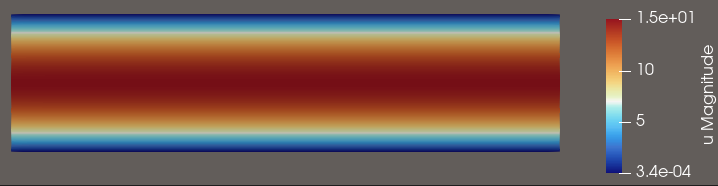
### Pressure profile in the same case 
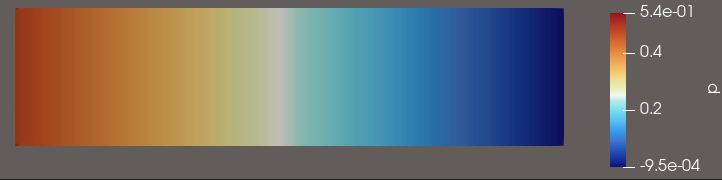


The results seem satisfactory. The velocity profile looks relevant as well as the pressure profile. The next steps would be to compute the error of the numeric solution for an easy scenario. And, to implement the mass matrix to make the problem, non-stationnary.